In [1]:
from keras import layers
import keras
import keras.backend as K

import numpy as np
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#from google.colab import files
#files.upload()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
os.getcwd()

'/content'

In [5]:
import glob

glob.glob("./drive/My Drive/all_npy/*")

['./drive/My Drive/all_npy/ok_test.npy',
 './drive/My Drive/all_npy/anomal.npy',
 './drive/My Drive/all_npy/ok.npy']

In [6]:
ok=np.load('./drive/My Drive/all_npy/ok.npy')
ano=np.load('./drive/My Drive/all_npy/anomal.npy')


In [7]:
ok_test=np.load('./drive/My Drive/all_npy/ok_test.npy')

In [8]:
ok.shape

(7128, 300, 114, 1)

In [9]:
ano.shape

(28, 300, 114, 1)

In [10]:
#A=np.concatenate((ano,ano), axis = 0) 

In [11]:
# ハードウェア情報取得
import tensorflow as tf

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

if tpu:
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu, steps_per_run=128) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)


# モデル作成やモデルロード、モデルコンパイル時に、with strategy.scope()で囲む
#from tensorflow import keras
#with strategy.scope():
#    model = make_model()


Running on single GPU  /device:GPU:0
Number of accelerators:  1


# Models

In [12]:
width = 224
height = 224
channels = 1

## Generators Encoder


In [13]:
input_layer = layers.Input(name='input', shape=(height, width, channels))
    # Encoder
x = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='conv_1', kernel_regularizer = 'l2')(input_layer)
x = layers.LeakyReLU(name='leaky_1')(x)

x = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='conv_2', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_1')(x)
x = layers.LeakyReLU(name='leaky_2')(x)

x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_3', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_2')(x)
x = layers.LeakyReLU(name='leaky_3')(x)

x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_4', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_3')(x)
x = layers.LeakyReLU(name='leaky_4')(x)

x = layers.GlobalAveragePooling2D(name='g_encoder_output')(x)

g_e = keras.models.Model(inputs=input_layer, outputs=x)

g_e.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 32)      832       
_________________________________________________________________
leaky_1 (LeakyReLU)          (None, 224, 224, 32)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 64)      18496     
_________________________________________________________________
norm_1 (BatchNormalization)  (None, 112, 112, 64)      256       
_________________________________________________________________
leaky_2 (LeakyReLU)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 56, 56, 128)      

## Generator

In [14]:
input_layer = layers.Input(name='input', shape=(height, width, channels))

x = g_e(input_layer)

y = layers.Dense(width * width * 2, name='dense')(x) # 2 = 128 / 8 / 8
y = layers.Reshape((width//8, width//8, 128), name='de_reshape')(y)

y = layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', name='deconv_1', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_1')(y)

y = layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', name='deconv_2', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_2')(y)

y = layers.Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', name='deconv_3', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_3')(y)

y = layers.Conv2DTranspose(channels, (1, 1), strides=(1,1), padding='same', name='decoder_deconv_output', kernel_regularizer = 'l2', activation='tanh')(y)

g = keras.models.Model(inputs=input_layer, outputs=y)

g.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 1)]     0         
_________________________________________________________________
functional_1 (Functional)    (None, 128)               242048    
_________________________________________________________________
dense (Dense)                (None, 100352)            12945408  
_________________________________________________________________
de_reshape (Reshape)         (None, 28, 28, 128)       0         
_________________________________________________________________
deconv_1 (Conv2DTranspose)   (None, 56, 56, 128)       147584    
_________________________________________________________________
de_leaky_1 (LeakyReLU)       (None, 56, 56, 128)       0         
_________________________________________________________________
deconv_2 (Conv2DTranspose)   (None, 112, 112, 64)     

## Encoder

In [15]:
input_layer = layers.Input(name='input', shape=(height, width, channels))

z = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='encoder_conv_1', kernel_regularizer = 'l2')(input_layer)
z = layers.LeakyReLU()(z)

z = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='encoder_conv_2', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_1')(z)
z = layers.LeakyReLU()(z)


z = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='encoder_conv_3', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_2')(z)
z = layers.LeakyReLU()(z)

z = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_41', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_3')(z)
z = layers.LeakyReLU()(z)

z = layers.GlobalAveragePooling2D(name='encoder_output')(z)

encoder = keras.models.Model(input_layer, z)
encoder.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 1)]     0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 224, 224, 32)      832       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 224, 224, 32)      0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 112, 112, 64)      18496     
_________________________________________________________________
encoder_norm_1 (BatchNormali (None, 112, 112, 64)      256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 112, 112, 64)      0         
_________________________________________________________________
encoder_conv_3 (Conv2D)      (None, 56, 56, 128)      

## feature extractor

In [16]:
input_layer = layers.Input(name='input', shape=(height, width, channels))

f = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='f_conv_1', kernel_regularizer = 'l2')(input_layer)
f = layers.LeakyReLU(name='f_leaky_1')(f)

f = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='f_conv_2', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_1')(f)
f = layers.LeakyReLU(name='f_leaky_2')(f)


f = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='f_conv_3', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_2')(f)
f = layers.LeakyReLU(name='f_leaky_3')(f)


f = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='f_conv_4', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_3')(f)
f = layers.LeakyReLU(name='feature_output')(f)

feature_extractor = keras.models.Model(input_layer, f)

feature_extractor.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 1)]     0         
_________________________________________________________________
f_conv_1 (Conv2D)            (None, 224, 224, 32)      832       
_________________________________________________________________
f_leaky_1 (LeakyReLU)        (None, 224, 224, 32)      0         
_________________________________________________________________
f_conv_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
f_norm_1 (BatchNormalization (None, 112, 112, 64)      256       
_________________________________________________________________
f_leaky_2 (LeakyReLU)        (None, 112, 112, 64)      0         
_________________________________________________________________
f_conv_3 (Conv2D)            (None, 56, 56, 128)      

## gan trainer

In [17]:
class AdvLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AdvLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori_feature = feature_extractor(x[0])
        gan_feature = feature_extractor(x[1])
        return K.mean(K.square(ori_feature - K.mean(gan_feature, axis=0)))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
class CntLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CntLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori = x[0]
        gan = x[1]
        return K.mean(K.abs(ori - gan))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
class EncLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EncLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori = x[0]
        gan = x[1]
        return K.mean(K.square(g_e(ori) - encoder(gan)))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
# model for training
input_layer = layers.Input(name='input', shape=(height, width, channels))
gan = g(input_layer) # g(x)

adv_loss = AdvLoss(name='adv_loss')([input_layer, gan])
cnt_loss = CntLoss(name='cnt_loss')([input_layer, gan])
enc_loss = EncLoss(name='enc_loss')([input_layer, gan])

gan_trainer = keras.models.Model(input_layer, [adv_loss, cnt_loss, enc_loss])

# loss function
def loss(yt, yp):
    return yp

losses = {
    'adv_loss': loss,
    'cnt_loss': loss,
    'enc_loss': loss,
}

lossWeights = {'cnt_loss': 20.0, 'adv_loss': 1.0, 'enc_loss': 1.0}

# compile
gan_trainer.compile(optimizer = 'adam', loss=losses, loss_weights=lossWeights)

In [18]:
gan_trainer.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 224, 224, 1)  13427329    input[0][0]                      
__________________________________________________________________________________________________
adv_loss (AdvLoss)              ()                   0           input[0][0]                      
                                                                 functional_3[0][0]               
__________________________________________________________________________________________________
cnt_loss (CntLoss)              ()                   0           input[0][0]           

## discriminator

In [19]:
input_layer = layers.Input(name='input', shape=(height, width, channels))

f = feature_extractor(input_layer)

d = layers.GlobalAveragePooling2D(name='glb_avg')(f)
d = layers.Dense(1, activation='sigmoid', name='d_out')(d)
    
d = keras.models.Model(input_layer, d)
d.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 1)]     0         
_________________________________________________________________
functional_7 (Functional)    (None, 28, 28, 128)       242048    
_________________________________________________________________
glb_avg (GlobalAveragePoolin (None, 128)               0         
_________________________________________________________________
d_out (Dense)                (None, 1)                 129       
Total params: 242,177
Trainable params: 241,537
Non-trainable params: 640
_________________________________________________________________


In [20]:
d.compile(optimizer='adam', loss='binary_crossentropy')

In [21]:
def reshape_x(x):
    new_x = np.empty((len(x), width, height))
    for i, e in enumerate(x):
        new_x[i] = cv2.resize(e, (width, height))
    return np.expand_dims(new_x, axis=-1) / 127 - 1


In [22]:
import cv2
import numpy as np

In [23]:
ok.shape

(7128, 300, 114, 1)

In [24]:
ano.shape

(28, 300, 114, 1)

In [25]:
ok_test.shape

(561, 300, 114, 1)

In [26]:
x_ok=ok-np.mean(ok)

In [27]:
x_test=ano-np.mean(ano)

In [28]:
ok_test=ok_test-np.mean(ok_test)

In [29]:
x_test.shape

(28, 300, 114, 1)

In [30]:
 re_x_ok=reshape_x(x_ok)
 re_x_test=reshape_x(x_test)

In [31]:
re_ok_test=reshape_x(ok_test)

In [32]:
 re_x_test.shape

(28, 224, 224, 1)

# Load Data

# Training

In [37]:
niter = 2000
bz = 32

In [38]:
def get_data_generator(data, batch_size=32):
    datalen = len(data)
    cnt = 0
    while True:
        idxes = np.arange(datalen)
        np.random.shuffle(idxes)
        cnt += 1
        for i in range(int(np.ceil(datalen/batch_size))):
            train_x = np.take(data, idxes[i*batch_size: (i+1) * batch_size], axis=0)
            y = np.ones(len(train_x))
            yield train_x, [y, y, y]

In [39]:
train_data_generator = get_data_generator(re_x_ok, bz)

In [40]:
for i in range(niter):
    ### get batch x, y ###
    x, y = train_data_generator.__next__()
    ### train disciminator ###
    d.trainable = True
    fake_x = g.predict(x)
    d_x = np.concatenate([x, fake_x], axis=0)
    d_y = np.concatenate([np.zeros(len(x)), np.ones(len(fake_x))], axis=0)
    d_loss = d.train_on_batch(d_x, d_y)
    ### train generator ###
    d.trainable = False 
    g_loss = gan_trainer.train_on_batch(x, y)
    #g_loss include adv cnt enc loss, and what is last one ?

    if i % 50 == 0:
        print(f'niter: {i+1}, g_loss: {g_loss}, d_loss: {d_loss}')

niter: 1, g_loss: [25.331661224365234, 0.005492018070071936, 1.006786584854126, 0.02747754380106926], d_loss: 3.8702642917633057
niter: 51, g_loss: [2.407402515411377, 3.6985053156968206e-05, 0.022051716223359108, 0.0031000312883406878], d_loss: 1.4882144927978516
niter: 101, g_loss: [1.338771939277649, 7.194998761406168e-05, 0.024600837379693985, 0.00016639243403915316], d_loss: 0.9391098618507385
niter: 151, g_loss: [0.9661574363708496, 1.1881797036039643e-05, 0.02598590776324272, 0.0019787633791565895], d_loss: 0.6377711296081543
niter: 201, g_loss: [0.7332077622413635, 0.004943707957863808, 0.022223815321922302, 0.004886197857558727], d_loss: 0.5675918459892273
niter: 251, g_loss: [0.6961334347724915, 0.007200116291642189, 0.023385699838399887, 0.005647266749292612], d_loss: 0.48900336027145386
niter: 301, g_loss: [0.6480772495269775, 0.0036468522157520056, 0.022912170737981796, 0.00412960909307003], d_loss: 0.34651854634284973
niter: 351, g_loss: [0.5915796160697937, 0.00322260987

# Evaluation

In [33]:
re_x_test.shape

(28, 224, 224, 1)

In [34]:
re_ok_test.shape

(561, 224, 224, 1)

In [35]:

cat_test=np.concatenate((re_x_test,re_ok_test), axis = 0) 

#cat_test =np.concatenate(re_x_test,re_ok_test,0)

In [65]:
y_test = np.array([1, 0])
y_test=np.repeat(y_test, [re_x_test.shape[0], re_ok_test.shape[0]], axis=0)

In [41]:
encoded = g_e.predict(cat_test)
gan_x = g.predict(cat_test)
encoded_gan = g_e.predict(gan_x)
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1

In [44]:
cat_test.shape

(589, 224, 224, 1)

28

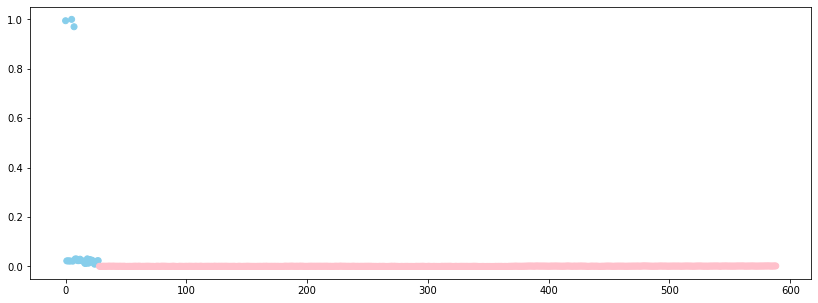

In [66]:
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5
plt.scatter(range(cat_test.shape[0]), score, c=['skyblue' if x == 1 else 'pink' for x in y_test])

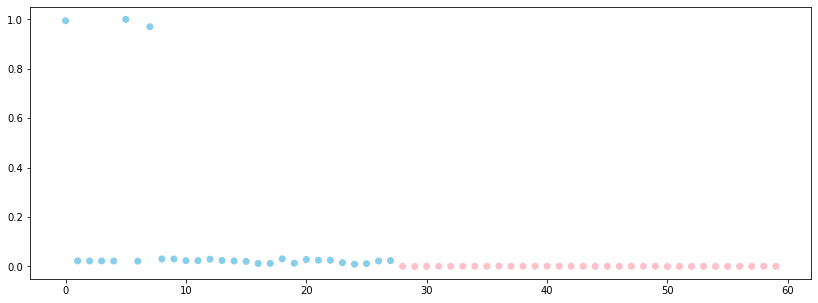

In [67]:
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5
plt.scatter(range(60), score[0:60], c=['skyblue' if x == 1 else 'pink' for x in y_test[0:60]])

0.994474

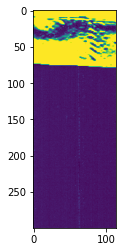

In [84]:
o=0
plt.imshow(np.squeeze(ano[o]))
score[o]

In [68]:
niter = 9000
bz = 32

for i in range(niter):
    ### get batch x, y ###
    x, y = train_data_generator.__next__()
    ### train disciminator ###
    d.trainable = True
    fake_x = g.predict(x)
    d_x = np.concatenate([x, fake_x], axis=0)
    d_y = np.concatenate([np.zeros(len(x)), np.ones(len(fake_x))], axis=0)
    d_loss = d.train_on_batch(d_x, d_y)
    ### train generator ###
    d.trainable = False 
    g_loss = gan_trainer.train_on_batch(x, y)
    #g_loss include adv cnt enc loss, and what is last one ?

    if i % 50 == 0:
        print(f'niter: {i+1}, g_loss: {g_loss}, d_loss: {d_loss}')


niter: 1, g_loss: [0.5386757254600525, 0.033427298069000244, 0.020485972985625267, 0.005052982829511166], d_loss: 0.9508447647094727
niter: 51, g_loss: [0.5774996876716614, 0.07288149744272232, 0.021182147786021233, 0.004650312475860119], d_loss: 0.34400153160095215
niter: 101, g_loss: [0.5630175471305847, 0.017012150958180428, 0.023816170170903206, 0.0025601584929972887], d_loss: 0.17887014150619507
niter: 151, g_loss: [0.5080448389053345, 0.001581963850185275, 0.02184787020087242, 0.005616161972284317], d_loss: 0.8389103412628174
niter: 201, g_loss: [0.5958223938941956, 0.005018576048314571, 0.026037460193037987, 0.008773170411586761], d_loss: 0.20858193933963776
niter: 251, g_loss: [0.4772934913635254, 0.005303056910634041, 0.02058734931051731, 0.004717960488051176], d_loss: 0.21695050597190857
niter: 301, g_loss: [0.4998587667942047, 0.0022313501685857773, 0.021620050072669983, 0.009008531458675861], d_loss: 0.9885870814323425
niter: 351, g_loss: [0.5443614721298218, 0.029131658375

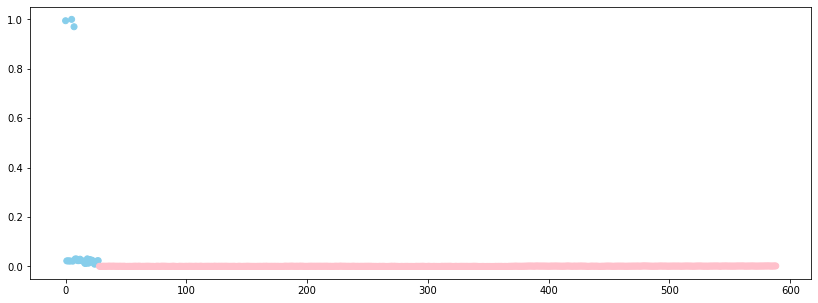

In [70]:
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5
plt.scatter(range(cat_test.shape[0]), score, c=['skyblue' if x == 1 else 'pink' for x in y_test])

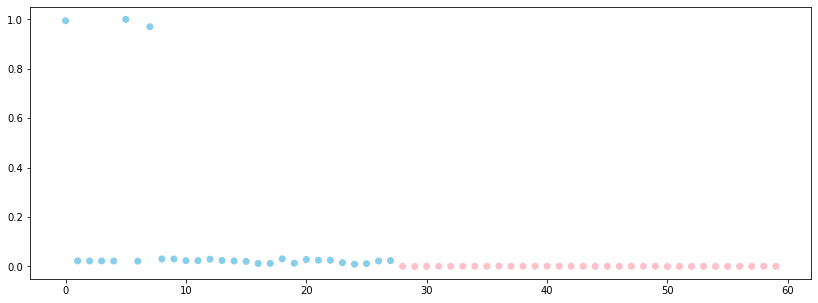

In [69]:
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5
plt.scatter(range(60), score[0:60], c=['skyblue' if x == 1 else 'pink' for x in y_test[0:60]])

In [ ]:
niter = 10000
bz = 32

for i in range(niter):
    ### get batch x, y ###
    x, y = train_data_generator.__next__()
    ### train disciminator ###
    d.trainable = True
    fake_x = g.predict(x)
    d_x = np.concatenate([x, fake_x], axis=0)
    d_y = np.concatenate([np.zeros(len(x)), np.ones(len(fake_x))], axis=0)
    d_loss = d.train_on_batch(d_x, d_y)
    ### train generator ###
    d.trainable = False 
    g_loss = gan_trainer.train_on_batch(x, y)
    #g_loss include adv cnt enc loss, and what is last one ?

    if i % 50 == 0:
        print(f'niter: {i+1}, g_loss: {g_loss}, d_loss: {d_loss}')

encoded = g_e.predict(x_test)
gan_x = g.predict(x_test)
encoded_gan = g_e.predict(gan_x)
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1

from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5
plt.scatter(range(len(x_test)), score, c=['skyblue' if x == 1 else 'pink' for x in y_test])

#sum 20000

In [ ]:
niter = 80000
bz = 32

for i in range(niter):
    ### get batch x, y ###
    x, y = train_data_generator.__next__()
    ### train disciminator ###
    d.trainable = True
    fake_x = g.predict(x)
    d_x = np.concatenate([x, fake_x], axis=0)
    d_y = np.concatenate([np.zeros(len(x)), np.ones(len(fake_x))], axis=0)
    d_loss = d.train_on_batch(d_x, d_y)
    ### train generator ###
    d.trainable = False 
    g_loss = gan_trainer.train_on_batch(x, y)
    #g_loss include adv cnt enc loss, and what is last one ?

    if i % 50 == 0:
        print(f'niter: {i+1}, g_loss: {g_loss}, d_loss: {d_loss}')

encoded = g_e.predict(x_test)
gan_x = g.predict(x_test)
encoded_gan = g_e.predict(gan_x)
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1

from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5
plt.scatter(range(len(x_test)), score, c=['skyblue' if x == 1 else 'pink' for x in y_test])

#sum 100000

In [ ]:
niter = 400000
bz = 32

for i in range(niter):
    ### get batch x, y ###
    x, y = train_data_generator.__next__()
    ### train disciminator ###
    d.trainable = True
    fake_x = g.predict(x)
    d_x = np.concatenate([x, fake_x], axis=0)
    d_y = np.concatenate([np.zeros(len(x)), np.ones(len(fake_x))], axis=0)
    d_loss = d.train_on_batch(d_x, d_y)
    ### train generator ###
    d.trainable = False 
    g_loss = gan_trainer.train_on_batch(x, y)
    #g_loss include adv cnt enc loss, and what is last one ?

    if i % 50 == 0:
        print(f'niter: {i+1}, g_loss: {g_loss}, d_loss: {d_loss}')

encoded = g_e.predict(x_test)
gan_x = g.predict(x_test)
encoded_gan = g_e.predict(gan_x)
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1

from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5
plt.scatter(range(len(x_test)), score, c=['skyblue' if x == 1 else 'pink' for x in y_test])

##sum 500000

In [ ]:
i=4
y_test[i:i+1]

In [ ]:
image = np.reshape(gan_x[i:i+1], (64, 64))
image = image * 127 + 127
plt.imshow(image.astype(np.uint8), cmap='gray')

In [ ]:
image = np.reshape(x_test[i:i+1], (64, 64))
image = image * 127 + 127
plt.imshow(image.astype(np.uint8), cmap='gray')

In [ ]:
i=1
y_test[i:i+1]

In [ ]:
image = np.reshape(gan_x[i:i+1], (64, 64))
image = image * 127 + 127
plt.imshow(image.astype(np.uint8), cmap='gray')

In [ ]:
image = np.reshape(x_test[i:i+1], (64, 64))
image = image * 127 + 127
plt.imshow(image.astype(np.uint8), cmap='gray')

In [ ]:
#x_ok = x_train[y_train == 1]

(x_train2, y_train2), (x_test2, y_test2) = mnist.load_data()

x_test_7 = x_test2[y_test2 == 7]
x_test_7 = reshape_x(x_test_7)

x_test_1 = x_test2[y_test2 == 1]
x_test_1 = reshape_x(x_test_1)

y_test_7 = y_test2[y_test2 == 7]
y_test_1 = y_test2[y_test2 == 1]

In [ ]:
encoded = g_e.predict(x_test_7)
gan_x = g.predict(x_test_7)
encoded_gan = g_e.predict(gan_x)
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1

In [ ]:
score_7=score

In [ ]:
encoded = g_e.predict(x_test_1)
gan_x = g.predict(x_test_1)
encoded_gan = g_e.predict(gan_x)
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1

In [ ]:
score_ok_1=score

In [ ]:


sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set1')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

labels = ['lab_ok_1', 'lab_7']
ax.hist(score_ok_1, bins=50, alpha=0.6,label=labels[0])
ax.hist(score_7, bins=50, alpha=0.6,label=labels[1])
ax.set_xlabel('length [cm]')

plt.legend()
plt.show()

In [ ]:
#x_ok = x_train[y_train == 1]

(x_train2, y_train2), (x_test2, y_test2) = mnist.load_data()

x_test_5 = x_test2[y_test2 == 5]
x_test_5 = reshape_x(x_test_5)

x_test_1 = x_test2[y_test2 == 1]
x_test_1 = reshape_x(x_test_1)

y_test_5 = y_test2[y_test2 == 5]
y_test_1 = y_test2[y_test2 == 1]

In [ ]:
encoded = g_e.predict(x_test_5)
gan_x = g.predict(x_test_5)
encoded_gan = g_e.predict(gan_x)
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1

In [ ]:
score_5=score

In [ ]:
encoded = g_e.predict(x_test_1)
gan_x = g.predict(x_test_1)
encoded_gan = g_e.predict(gan_x)
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1

In [ ]:
score_1=score

In [ ]:

import seaborn as sns

sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set1')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

labels = ['lab_1', 'lab_5']
ax.hist(score_1, bins=50, alpha=0.6,label=labels[0])
ax.hist(score_5, bins=50, alpha=0.6,label=labels[1])
ax.set_xlabel('length [cm]')

plt.legend()
plt.show()

In [ ]:
#学習回数が少なすぎると1の画像が正規分布しない
#何回学習したら綺麗に分かれるのか上で検証してみる

In [ ]:
g.save_weights('g.h5')

In [ ]:
g_e.save_weights('g_e.h5')

In [ ]:
from keras import layers
import keras
import keras.backend as K


import numpy as np
import seaborn as sns

In [ ]:
width = 64
height = 64
channels = 1

In [ ]:
input_layer = layers.Input(name='input', shape=(height, width, channels))

# Encoder
x = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='conv_1', kernel_regularizer = 'l2')(input_layer)
x = layers.LeakyReLU(name='leaky_1')(x)

x = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='conv_2', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_1')(x)
x = layers.LeakyReLU(name='leaky_2')(x)


x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_3', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_2')(x)
x = layers.LeakyReLU(name='leaky_3')(x)


x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_4', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_3')(x)
x = layers.LeakyReLU(name='leaky_4')(x)

x = layers.GlobalAveragePooling2D(name='g_encoder_output')(x)

g_e = keras.models.Model(inputs=input_layer, outputs=x)

g_e.summary()

In [ ]:
input_layer = layers.Input(name='input', shape=(height, width, channels))

x = g_e(input_layer)

y = layers.Dense(width * width * 2, name='dense')(x) # 2 = 128 / 8 / 8
y = layers.Reshape((width//8, width//8, 128), name='de_reshape')(y)

y = layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', name='deconv_1', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_1')(y)

y = layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', name='deconv_2', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_2')(y)

y = layers.Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', name='deconv_3', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_3')(y)

y = layers.Conv2DTranspose(channels, (1, 1), strides=(1,1), padding='same', name='decoder_deconv_output', kernel_regularizer = 'l2', activation='tanh')(y)

g = keras.models.Model(inputs=input_layer, outputs=y)

g.summary()

In [ ]:
g.load_weights('g.h5')

In [ ]:
g_e.load_weights('g_e.h5')

In [ ]:
from keras.datasets import mnist
import cv2
import numpy as np



In [ ]:
def reshape_x(x):
    new_x = np.empty((len(x), width, height))
    for i, e in enumerate(x):
        new_x[i] = cv2.resize(e, (width, height))
    return np.expand_dims(new_x, axis=-1) / 127 - 1
  

In [ ]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_test_6 = x_test[y_test == 6]
x_test_6 = reshape_x(x_test_6)

x_test_1 = x_test[y_test == 1]
x_test_1 = reshape_x(x_test_1)

y_test_6 = y_test[y_test == 6]
y_test_1 = y_test[y_test == 1]

In [ ]:
encoded = g_e.predict(x_test_6)
gan_x = g.predict(x_test_6)
encoded_gan = g_e.predict(gan_x)
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1

In [ ]:
fin_weight_score_6=score

In [ ]:
encoded = g_e.predict(x_test_1)
gan_x = g.predict(x_test_1)
encoded_gan = g_e.predict(gan_x)
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1

In [ ]:
fin_weight_score_1=score

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set1')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

labels = ['fin_weight_lab_1', 'fin_weight_lab_6']
ax.hist(fin_weight_score_1, bins=50, alpha=0.6,label=labels[0])
ax.hist(fin_weight_score_6, bins=50, alpha=0.6,label=labels[1])
ax.set_xlabel('length [cm]')

plt.legend()
plt.show()